In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
# CURRENTLY THIS NOTEBOOK IS BROKEN
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

First, load unique data points

In [17]:
train_data = load_data_from_file("../../data/graph_data.json") # dictionary of SMILES and values are graphs
embeddings = pd.read_csv('../../embedding/final_embedding_dim30.csv')

/project/ai4s-hackathon/R2S2/shrihan/venvs/shri_gnnpytorch/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [18]:
embeddings

,Atoms,Orbital,Embeddings
0,B,1s,[ 0.7674839 -1.064584 1.375875 4.891208...
1,C,1s,[ 1.4762408 -0.5725381 -3.6370533 -3.381879...
2,F,1s,[ 3.5082635e-01 5.3094700e-04 -8.5528314e-01 ...
3,Li,1s,[ -0.9012349 0.45608097 -1.4500529 -0.68...
4,Mg,1s,[ -5.154729 5.9465804 10.670059 4.06454...
...,...,...,...
100,Xe,4s,[-0.00260831 -0.03788212 0.05341679 0.044250...
101,Hg,5d5/2,[ 4.4642348e+00 -5.6740198e+00 -3.0377681e+00 ...
102,Pb,5d5/2,[-1.1037469 -5.14788 -0.6410701 1.611648...
103,Hg,5p3/2,[ 4.4642348e+00 -5.6740198e+00 -3.0377681e+00 ...


In [19]:
def convert_to_embedding(atom, orbital, embeddings):
    """
    Convert graph dictionary to embedding matrix.
    """
    
    # Embedding IDs
    change_to_list = lambda x: list(np.fromstring(x.replace('\n','').strip('[]'), sep=' '))
    emb_vector = embeddings[(embeddings['Atoms'] == atom) & (embeddings['Orbital'] == orbital)]["Embeddings"].iloc[0]
    
    return change_to_list(emb_vector)
    

In [20]:
# get all the unique atom types, orbitals and their respective binding energies

atoms = []
charges = []
orbs = []
energies = []
embedded_vectors = []


for mol in train_data:
    graph = train_data[mol]

    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())

    for i in range(len(orb)):
        for j in range(len(orb[i])):
            if energy[i][j]!=-1:
                atoms.append(atom[i])
                charges.append(charge[i])
                orbs.append(orb[i][j])
                energies.append(energy[i][j])
                embedded_vectors.append(convert_to_embedding(atom[i], orb[i][j], embeddings))

In [32]:
# convert to pandas dataframe
data_df = pd.DataFrame({'Atoms': atoms, 'Charges': charges, 'Orbitals': orbs, 'Energies': energies, 'Embedded_Vectors': embedded_vectors})


In [33]:
data_df

,Atoms,Charges,Orbitals,Energies,Embedded_Vectors
0,Ag,0,3d5/2,375.550,"[6.735933, -6.153499, -1.8008256, -2.9908068, ..."
1,C,0,1s,293.250,"[1.4762408, -0.5725381, -3.6370533, -3.3818793..."
2,C,0,1s,293.250,"[1.4762408, -0.5725381, -3.6370533, -3.3818793..."
3,C,0,1s,293.250,"[1.4762408, -0.5725381, -3.6370533, -3.3818793..."
4,C,0,1s,293.250,"[1.4762408, -0.5725381, -3.6370533, -3.3818793..."
...,...,...,...,...,...
5187,Xe,0,3d5/2,683.510,"[-0.00260831, -0.03788212, 0.05341679, 0.04425..."
5188,Xe,0,4d5/2,72.800,"[-0.00260831, -0.03788212, 0.05341679, 0.04425..."
5189,Zn,0,2p3/2,1031.100,"[4.8023996, -1.4093881, -0.6706622, 1.7053568,..."
5190,Zn,0,3p3/2,96.100,"[4.8023996, -1.4093881, -0.6706622, 1.7053568,..."


Encode these data points, both atomic number and quantum numbers for orbitals

In [122]:
atom_dict = {
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

atom_number_dict = {v: k for k, v in atom_dict.items()}


orb_dict = {
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
 '4p3/2': [4, 1, 1.5],
 '3d5/2': [3, 2, 2.5],
 '3d': [3, 2, 0],
 '5p3/2': [5, 1, 1.5],
 '2s': [2, 0, 0],
 '1s': [1, 0, 0],
 '4s': [4, 0, 0],
 '3p': [3, 1, 0],
 '5d5/2': [5, 2, 2.5],
 '5s': [5, 0, 0],
 '3s': [3, 0, 0],
 '3p3/2': [3, 1, 1.5],
 '4d5/2': [4, 2, 2.5],
 '4d': [4, 2, 0],
 '4f7/2': [4, 3, 3.5]
}

In [127]:
def convert_raw_to_features(atom, orbital, charge):
    """
    Convert raw data to features.
    """
    atom = atom_dict[atom]
    orbital = orb_dict[orbital]
    charge = charge
    return list(np.concatenate((np.array([atom]), np.array(orbital), np.array([charge]))))

def convert_features_to_raw(features):
    """
    Convert features to raw data.
    """
    atom = features[0]
    orbital = features[1:4]
    charge = features[4]
    
    atom = atom_number_dict[np.round(atom, 0)]
    
    for key, value in orb_dict.items():
        if np.array_equal(orbital, value):
            orbital = key
            break
            
    return atom, orbital, charge

In [ ]:
raw_features = []

for i in range(len(atoms)):
    feature_i = convert_raw_to_features(atoms[i], orbs[i], charges[i])
    raw_features.append(feature_i)
    
data_df['Raw_Features'] = raw_features

In [78]:
scaler = MinMaxScaler()
rf = np.array(data_df['Raw_Features'].to_list())
features = scaler.fit_transform(rf)
log_energies = np.log10(data_df['Energies'].values)
embedded_data = np.array(data_df['Embedded_Vectors'].to_list())

In [79]:
features.shape,  embedded_data.shape, log_energies.reshape(5192, 1).shape

((5192, 5), (5192, 31), (5192, 1))

In [80]:
data = np.concatenate([features, embedded_data, np.expand_dims(log_energies, axis=1)], axis=1)

In [81]:
# example datapoint
data[0]

array([  0.49438202,   0.5       ,   0.66666667,   0.71428571,
         0.25      ,   6.735933  ,  -6.153499  ,  -1.8008256 ,
        -2.9908068 ,   0.48990375,   2.2316253 ,  -0.21028805,
        -1.2430507 ,   0.94597477,   0.09425366,  -1.2222649 ,
        -0.81588507,   2.032324  ,   7.849218  ,   3.0435503 ,
        -3.0817854 ,  -3.3048282 ,   0.6487707 ,   4.5218997 ,
         0.80362695,   0.49908733,   4.5457454 ,   8.526806  ,
         1.712713  ,   0.55380374, -10.5964365 ,   8.409174  ,
        -7.5938244 ,   1.912712  ,  16.921257  ,   0.24289064,
         2.57466777])

Let us split into training and testing sets

In [82]:
data_train, data_test = train_test_split(data, train_size=0.8)
data_train = np.float64(data_train)
data_test = np.float64(data_test)

First, the training - let us split into input and output vectors

In [83]:
X_train = data_train[:,:-1]
y_train = data_train[:,-1]
y_train = y_train.reshape(-1, 1)

In [84]:
# Define the MLP model
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc3(x)
        return x

In [171]:
# Model parameters
input_size = 36
hidden_size = 64
output_size = 1
batch_size = 8
learning_rate = 1e-2
num_epochs = 100

In [172]:
# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [173]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/project/ai4s-hackathon/R2S2/shrihan/venvs/shri_gnnpytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [174]:
# Split training data into train and validation
X_train_actual, X_val, y_train_actual, y_val = train_test_split(
    X_train, y_train, test_size=0.001, random_state=42
)

In [175]:
# Create datasets and dataloaders
train_dataset = TensorDataset(
    torch.tensor(X_train_actual, dtype=torch.float32),
    torch.tensor(y_train_actual, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

In [176]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Training loop with validation
train_losses = []
val_losses = []

best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += F.mse_loss(outputs, targets).item()

    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Learning rate adjustment
    scheduler.step(val_loss)

    # Print metrics and save best model
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_save/best_model_emb_norm.pt')

Evaluate model predictions on test set

In [92]:
X_test = data_test[:,:-1] # features except `log_energies` the last column

In [98]:
X_orig = scaler.inverse_transform(X_test[:, :5]) # atomic number, orbital, charge

In [134]:
X_raw = np.array([convert_features_to_raw(X_orig[i]) for i in range(X_orig.shape[0])])

In [148]:
X_orig

array([[ 6. ,  1. ,  0. ,  0. ,  0. ],
       [ 6. ,  1. ,  0. ,  0. ,  0. ],
       [24. ,  2. ,  1. ,  1.5,  0. ],
       ...,
       [ 6. ,  1. ,  0. ,  0. ,  0. ],
       [ 6. ,  1. ,  0. ,  0. ,  0. ],
       [ 6. ,  1. ,  0. ,  0. ,  0. ]])

In [161]:
atom_no = X_orig[:, 0]
orbital = X_orig[:, 1:4]
charge = X_orig[:, 4]

array([1., 1., 2., ..., 1., 1., 1.])

In [150]:
# Minimal batch prediction approach
# Kernel dies in the simplest approach

# Set model to evaluation mode
model.eval()

# Define a reasonable batch size
batch_size = 16

# Create empty array for predictions
num_samples = X_test.shape[0]
y_pred_test = np.zeros((num_samples, 1))

# Process in batches
for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_X = X_test[i:end_idx]

    # Convert to tensor, ensure float type
    batch_tensor = torch.tensor(batch_X, dtype=torch.float32)

    # Make prediction with no gradient tracking
    with torch.no_grad():
        y_pred_test[i:end_idx] = model(batch_tensor).numpy()

# Get actual test values and evaluate
y_test = data_test[:, -1].reshape(-1, 1)

In [151]:
np.mean((y_test-y_pred_test)**2)

0.027910810400106335

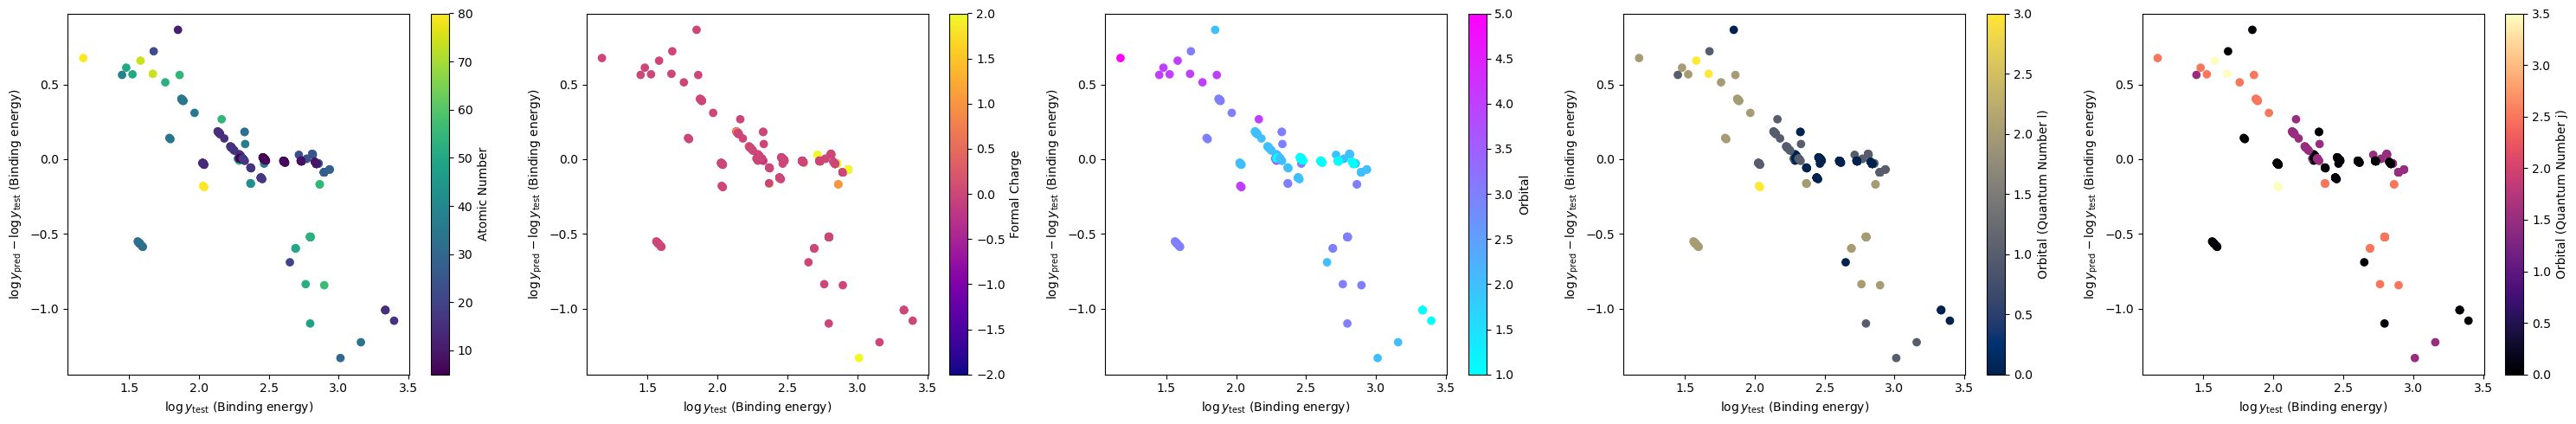

In [169]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))

# Subplot 1: Color by atomic number
sc1 = axes[0].scatter(y_test, y_pred_test - y_test, c=atom_no, cmap='viridis')
axes[0].set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
axes[0].set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Atomic Number')

# Subplot 2: Color by formal charge
sc2 = axes[1].scatter(y_test, y_pred_test - y_test, c=charge, cmap='plasma')
axes[1].set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
axes[1].set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Formal Charge')

# Subplot 3: Color by orbital
sc3 = axes[2].scatter(y_test, y_pred_test - y_test, c=orbital[:, 0], cmap='cool')
axes[2].set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
axes[2].set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')
cbar3 = plt.colorbar(sc3, ax=axes[2])
cbar3.set_label('Orbital')

# Subplot 4: Color by orbital[:, 1]
sc4 = axes[3].scatter(y_test, y_pred_test - y_test, c=orbital[:, 1], cmap='cividis')
axes[3].set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
axes[3].set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')
cbar4 = plt.colorbar(sc4, ax=axes[3])
cbar4.set_label('Orbital (Quantum Number l)')

# Subplot 5: Color by orbital[:, 2]
sc5 = axes[4].scatter(y_test, y_pred_test - y_test, c=orbital[:, 2], cmap='magma')
axes[4].set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
axes[4].set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')
cbar5 = plt.colorbar(sc5, ax=axes[4])
cbar5.set_label('Orbital (Quantum Number j)')


plt.tight_layout()
plt.show()

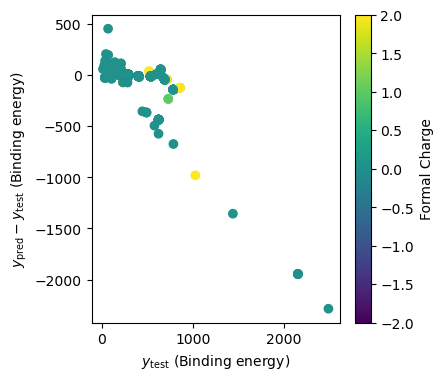

In [143]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.scatter(10 ** y_test, (10 ** y_pred_test) - (10 ** y_test), c = X_raw[:, 2].astype(float))
ax.set_xlabel(r'$y_\mathrm{test}$ (Binding energy)')
ax.set_ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$ (Binding energy)')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Formal Charge')

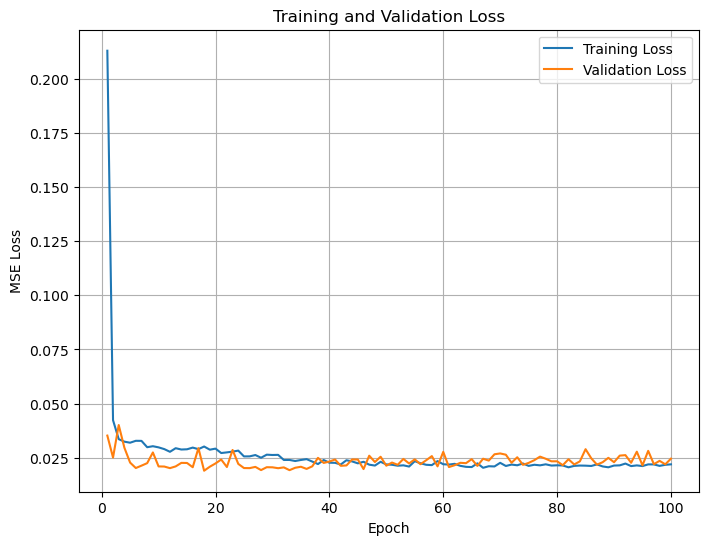

In [170]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()